#Linar probing the ImageGPT


##Environment Setup


### Load Datasets

In [ ]:
from google.colab import drive
import os

# Check if the mount point already contains files
if os.path.ismount('/content/drive'):
    print("Google Drive is already mounted.")
else:
    try:
        # Mount Google Drive with force_remount option
        drive.mount('/content/drive', force_remount=True)
        print("Google Drive mounted successfully.")
    except Exception as e:
        print(f"An error occurred while mounting Google Drive: {e}")

Mounted at /content/drive
Google Drive mounted successfully.


Here, the CIFAR-10 dataset is loaded using the datasets library, which provides a convenient way to load and preprocess data for machine learning models.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00


Here, only 5000 images is used for training and testing purpose

In [ ]:
from datasets import load_dataset

#dataset = load_dataset('cifar10')
dataset = load_dataset('cifar10', split={'train': 'train[:5000]', 'test': 'test[:5000]'})

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

### Load Pretrained ImageGPT model

Here, the ImageGPT model and its feature extractor are loaded. The model is configured to use a GPU if available, which would accelerate the processing.

In [ ]:
from transformers import ImageGPTFeatureExtractor, ImageGPTModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load the pre-trained feature extractor for ImageGPT
feature_extractor = ImageGPTFeatureExtractor.from_pretrained("openai/imagegpt-small")

#Load the pre-trained ImageGPT model(Here, the small imagegpt model is loaded for sake of saving computation resources)
Igptmodel = ImageGPTModel.from_pretrained("openai/imagegpt-small")

#Move the model to the GPU if available
Igptmodel.to(device)

preprocessor_config.json:   0%|          | 0.00/47.7k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/imagegpt/feature_extraction_imagegpt.py:28: FutureWarning: The class ImageGPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ImageGPTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/510 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/332M [00:00<?, ?B/s]

ImageGPTModel(
  (wte): Embedding(513, 512)
  (wpe): Embedding(1024, 512)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-23): 24 x ImageGPTBlock(
      (ln_1): ImageGPTLayerNorm()
      (attn): ImageGPTAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): ImageGPTLayerNorm()
      (mlp): ImageGPTMLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): QuickGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): ImageGPTLayerNorm()
)

## Feature Extraction from ImageGPT model

 ### Batch Processing for Feature Extraction
 Here, the code is designed to preprocess images for a neural network, feed them through the network to capture intermediate representations, and then organize these representations for each image and layer, facilitating their use in downstream machine learning tasks like linear probing or classification.

In [ ]:
import numpy as np

def extractor(samples_imgs):
    # Extracts a batch of images from the input samples_images.
    imgs = samples_imgs['img']

    # Convert each image in the batch to a NumPy array and ensure the data type is uint8.
    # Reformat each image from HWC (Height, Width, Channels) format to CHW (Channels, Height, Width) format.
    for i in range(len(imgs)):
        imgs[i] = np.array(imgs[i], dtype=np.uint8)
        imgs[i] = np.moveaxis(imgs[i], source=-1, destination=0)

    # This step includes normalization and other transformations to make the images compatible with ImageGPT.
    inputs = feature_extractor(imgs, return_tensors="pt")

    # Extract pixel values from the inputs from feature extractor and move them to the specified device (GPU or CPU).
    input_ids = inputs['input_ids'].to(device)

    # Perform a forward pass through the ImageGPT model to obtain the hidden states.
    with torch.no_grad():
        output = Igptmodel(input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states

    # For each layer in the ImageGPT model, average the hidden states across the sequence dimension.
    # This operation results in a single feature vector per image for each layer.
    # These feature vectors are then detached from the computation graph and converted to NumPy arrays.
    for i in range(len(hidden_states)):
        features = torch.mean(hidden_states[i],dim=1)
        samples_imgs[f'features_{i}'] = features.detach().cpu().numpy()

    return samples_imgs

### Applying Feature Extraction to Dataset

The feature extraction function is applied to the entire CIFAR-10 dataset using the .map function. This step converts the images in the dataset into a format that includes the extracted features for each layer of ImageGPT.

In [ ]:
processed_dataset = dataset.map(extractor, batched=True, batch_size=2)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:332: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

The dataset is converted into a format (numpy) that is more efficient for the subsequent processing steps.

In [ ]:
processed_dataset = processed_dataset.with_format("numpy")

In [ ]:
# Define your directory path
dir_path = "/content/drive/MyDrive/Colab Notebooks/ECE570/Final-Project"

# Check if the directory exists
if not os.path.exists(dir_path):
    try:
        # Create the directory if it doesn't exist
        os.makedirs(dir_path)
        print(f"Directory '{dir_path}' was created.")
    except Exception as e:
        # Handle any exception that might occur
        print(f"An error occurred while creating the directory: {e}")
else:
    print(f"Directory '{dir_path}' already exists.")

# Assuming 'processed_dataset' is your dataset variable
try:
    # Save the dataset to the specified directory
    processed_dataset.save_to_disk(dir_path)
    print(f"Dataset saved successfully in '{dir_path}'.")
except Exception as e:
    # Handle exceptions that might occur during save
    print(f"An error occurred while saving the dataset: {e}")

Directory '/content/drive/MyDrive/Colab Notebooks/ECE570/Final-Project' already exists.


Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset saved successfully in '/content/drive/MyDrive/Colab Notebooks/ECE570/Final-Project'.


##Training the Logistic Regression Model

Load the dataset from the specified directory. This is optional, if you have dataset into a format that includes the extracted features for each layer of ImageGPT saved on disk, then load it directly.

In [ ]:
from datasets import load_from_disk
dir_path = "/content/drive/MyDrive/Colab Notebooks/ECE570/Final-Project"
processed_dataset = load_from_disk(dir_path)

A logistic regression classifier is trained on the extracted features for each layer of the ImageGPT model. The performance of the classifier is evaluated and stored in a dictionary for both the training and test sets of CIFAR-10.

In [ ]:
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm


# Extract the training and test datasets
train_dataset = processed_dataset['train']
test_dataset = processed_dataset['test']

scores = dict()
for i in tqdm(range(Igptmodel.config.n_layer + 1)):
    # fit linear classifier
    lr_clf = LogisticRegression(max_iter=1000)
    lr_clf.fit(train_dataset[f'features_{i}'], train_dataset['label'])
    # compute accuracy on training + test set
    training_score = lr_clf.score(train_dataset[f'features_{i}'], train_dataset['label'])
    test_score = lr_clf.score(test_dataset[f'features_{i}'], test_dataset['label'])
    scores[f'features_{i}'] = (training_score, test_score)

Save the computed scores on disk(Optional)

In [ ]:
# Define your directory path
dir_path = "/content/drive/MyDrive/Colab Notebooks/ECE570/Final-Project"

# Function to save the results in pickle format
def save_results_to_disk(scores, directory, filename):
    # Create the full path for the file
    full_path = os.path.join(directory, filename)

    # Save scores
    with open(full_path, 'wb') as f:
        pickle.dump(scores, f)

save_results_to_disk(scores, dir_path, 'logistic_regression_scores.pkl')

Later on, you can load the precomputed results to avioid recomputing

In [ ]:
# turn keys into integers which we can sort
# with open(os.path.join(dir_path, 'logistic_regression_scores.pkl'), 'rb') as f:
#     scores = pickle.load(f)
values = {int(k.replace('features_', '')):v for k, v in scores.items()}
values = dict(sorted(values.items()))
values

{0: (0.4248, 0.2954),
 1: (0.4044, 0.3904),
 2: (0.456, 0.442),
 3: (0.4848, 0.4676),
 4: (0.51, 0.4912),
 5: (0.5304, 0.5226),
 6: (0.5582, 0.5414),
 7: (0.5928, 0.5808),
 8: (0.6472, 0.6212),
 9: (0.6774, 0.6592),
 10: (0.7674, 0.7476),
 11: (0.8056, 0.774),
 12: (0.7978, 0.7786),
 13: (0.81, 0.7822),
 14: (0.8014, 0.7708),
 15: (0.8096, 0.7716),
 16: (0.8136, 0.772),
 17: (0.793, 0.7514),
 18: (0.8164, 0.7592),
 19: (0.812, 0.736),
 20: (0.8318, 0.7268),
 21: (0.8236, 0.6964),
 22: (0.8346, 0.674),
 23: (0.831, 0.6648),
 24: (0.5702, 0.4834)}

Here, the accuracy of a Logistic Regression model across different layers of the ImageGPT model is been plotted , using the layer numbers as the x-axis and their corresponding accuracies as the y-axis.

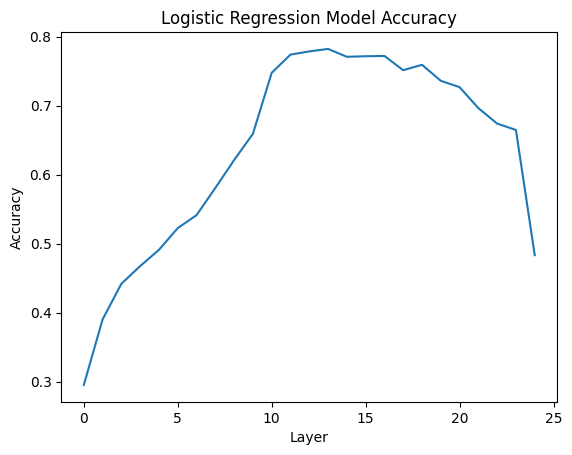

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()
ax.set_title('Logistic Regression Model Accuracy')
x = list(values.keys())
y = [value[1][1] for value in values.items()]
ax.set_xlabel('Layer')
ax.set_ylabel('Accuracy')

ax.plot(x, y)

## Understand the results

To better understand the layer that has the best performance and the last layer and why is the middle layer has the best performance, this segment of the code uses t-Distributed Stochastic Neighbor Embedding (t-SNE) for dimensionality reduction of features extracted from the best and worst layers of the ImageGPT model, identified as layers 13 and 24. For both layers, it applies t-SNE to reduce the features from the training and test datasets into two dimensions, making them suitable for visualization. The reduced features are then plotted using matplotlib, with different classes represented in different colors, to visually assess the separability of the classes based on the features from these layers. This visualization aids in understanding how well the features from the selected layers of the ImageGPT model differentiate between the various classes in the dataset.

### Result
From below graph, it can be seen that *at* the 13th layer, the training and test set features display clear class delineation, underscoring the discriminative
strength of the representations. Conversely, the last layer’s
visualization illustrates a muddled feature space, indicating
less class separability.

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

train_labels = train_dataset['label']
test_labels = test_dataset['label']

# Best and worst feature layers
best_layer_index = 13
worst_layer_index = 24

# Perform t-SNE dimensionality reduction on test features for the best layer
tsne_best = TSNE(n_components=2, random_state=42)
reduced_test_features_best = tsne_best.fit_transform(test_dataset[f'features_{best_layer_index}'])

# Perform t-SNE dimensionality reduction on test features for the worst layer
tsne_worst = TSNE(n_components=2, random_state=42)
reduced_test_features_worst = tsne_worst.fit_transform(test_dataset[f'features_{worst_layer_index}'])

In [ ]:
# Perform t-SNE dimensionality reduction on train features for the best layer
reduced_train_features_best = tsne_best.fit_transform(train_dataset[f'features_{best_layer_index}'])

# Perform t-SNE dimensionality reduction on train features for the worst layer
reduced_train_features_worst = tsne_worst.fit_transform(train_dataset[f'features_{worst_layer_index}'])

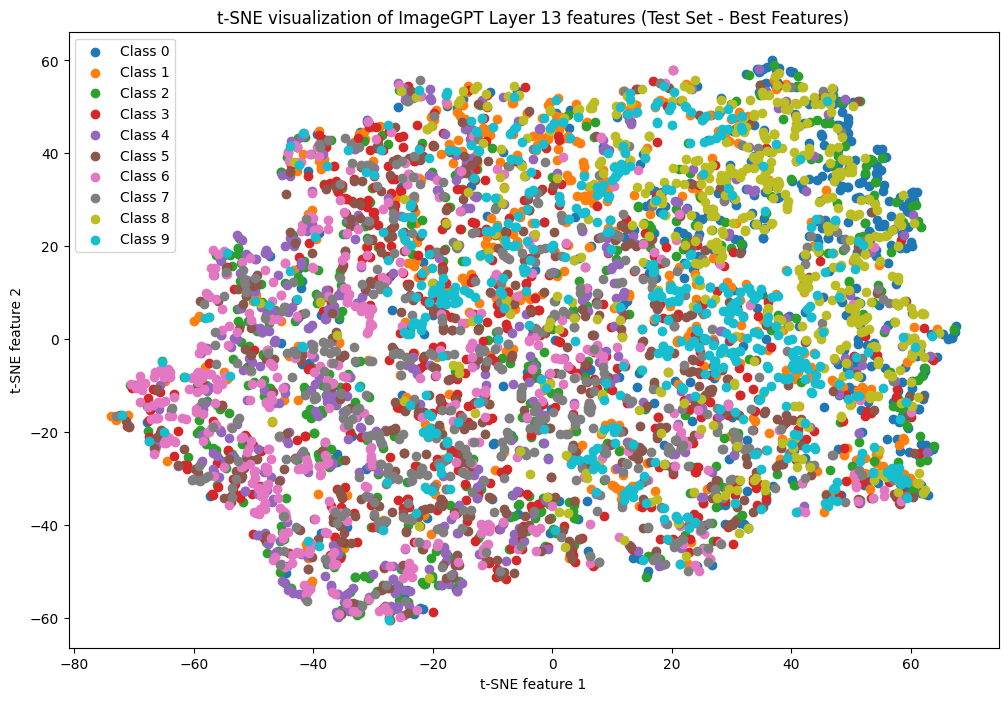

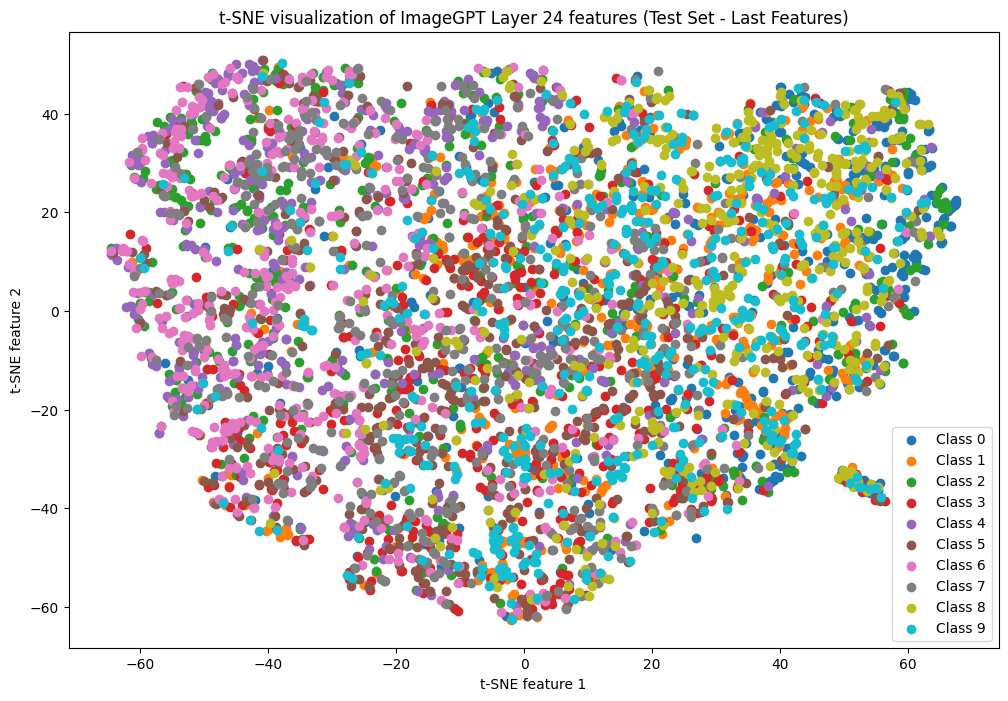

In [ ]:
# Plotting for best layer
plt.figure(figsize=(12, 8))
for i in range(10):
    indices = test_labels == i
    plt.scatter(reduced_test_features_best[indices, 0], reduced_test_features_best[indices, 1], label=f'Class {i}')
plt.legend()
plt.title('t-SNE visualization of ImageGPT Layer 13 features (Test Set - Best Features)')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

# Plotting for worst layer
plt.figure(figsize=(12, 8))
for i in range(10):
    indices = test_labels == i
    plt.scatter(reduced_test_features_worst[indices, 0], reduced_test_features_worst[indices, 1], label=f'Class {i}')
plt.legend()
plt.title('t-SNE visualization of ImageGPT Layer 24 features (Test Set - Last Features)')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

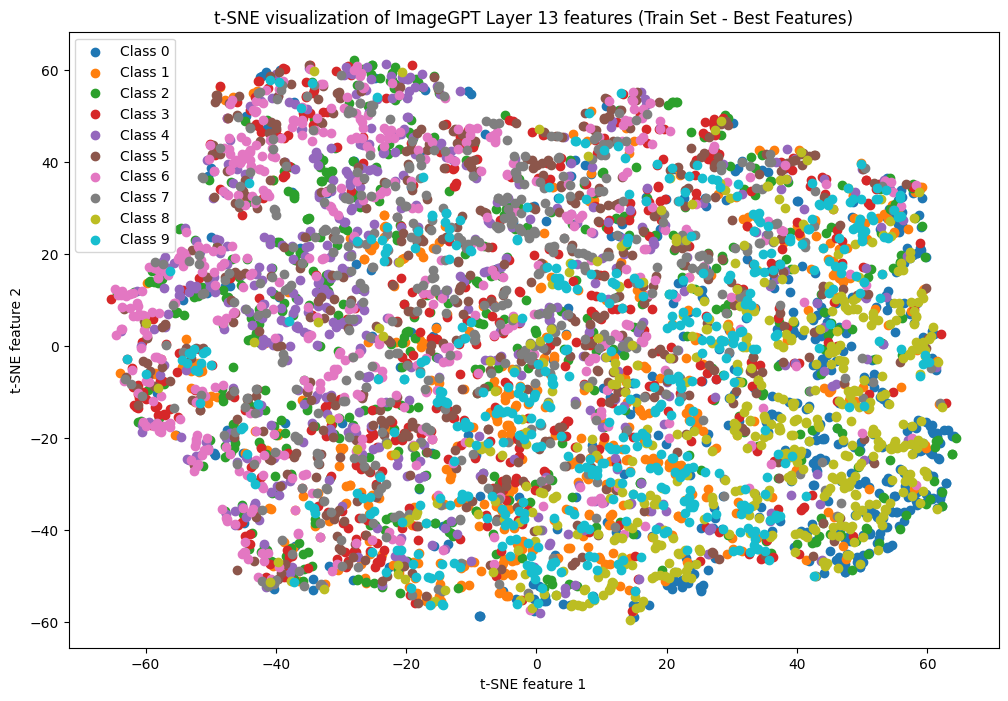

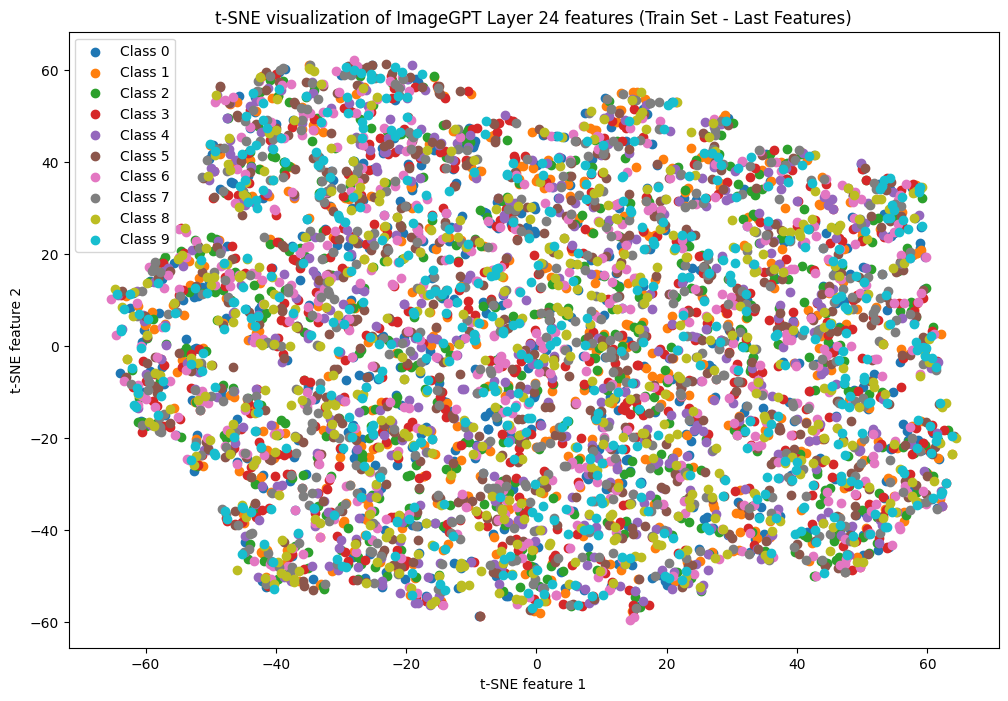

In [ ]:
# Plotting for best layer
plt.figure(figsize=(12, 8))
for i in range(10):
    indices = train_labels == i
    plt.scatter(reduced_train_features_best[indices, 0], reduced_train_features_best[indices, 1], label=f'Class {i}')
plt.legend()
plt.title('t-SNE visualization of ImageGPT Layer 13 features (Train Set - Best Features)')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

# Plotting for worst layer
plt.figure(figsize=(12, 8))
for i in range(10):
    indices = test_labels == i
    plt.scatter(reduced_train_features_best[indices, 0], reduced_train_features_best[indices, 1], label=f'Class {i}')
plt.legend()
plt.title('t-SNE visualization of ImageGPT Layer 24 features (Train Set - Last Features)')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

## Other Classfier
In addition with the basic logistic regression model, other classfier are further trained to evaluate which classfier is best suited for the ImageGPT model. The classifiers include a k-Nearest Neighbors (k-NN) classifier with 3 neighbors and a Multi-Layer Perceptron (MLP) neural network with two hidden layers containing 512 and 128 neurons, respectively. The `train_and_evaluate_models` function iterates over different layers of the ImageGPT model, using the features from each layer to train and evaluate the classifiers. It employs cross-validation to assess the models' performance and records both training and test accuracies for each layer and classifier, thus providing a comprehensive evaluation of how well different layers of the ImageGPT model contribute to classification tasks.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Define the models
ml_models = {
     'k-NN': KNeighborsClassifier(n_neighbors=3),
     'Neural Network': MLPClassifier(hidden_layer_sizes=(512, 128), max_iter=1000, random_state=42)
}

# Function to perform training and evaluation
def train_and_evaluate_models(train_data, test_data, models):
    cv_scores = {}
    train_test_scores = {}

    # Loop through each layer of the ImageGPT model
    for layer in tqdm(range(Igptmodel.config.n_layer + 1)):
        layer_key = f'features_{layer}'
        X_train = train_data[layer_key]
        y_train = train_data['label']
        X_test = test_data[layer_key]
        y_test = test_data['label']

        cv_scores[layer_key] = {}
        train_test_scores[layer_key] = {}

        # Evaluate each model
        for model_name, ml_model in models.items():
            # Cross-validation
            scores = cross_val_score(ml_model, X_train, y_train, cv=5)
            cv_scores[layer_key][model_name] = scores.mean()

            # Training and testing
            ml_model.fit(X_train, y_train)
            train_score = ml_model.score(X_train, y_train)
            test_score = ml_model.score(X_test, y_test)
            train_test_scores[layer_key][model_name] = (train_score, test_score)

    return cv_scores, train_test_scores

# Perform training and evaluation
cv_scores, train_test_scores = train_and_evaluate_models(processed_dataset['train'], processed_dataset['test'], ml_models)

Print the result

In [ ]:
# Assuming `train_test_scores` is a dictionary with layer keys and model accuracy tuples

# Initialize dictionaries to hold the accuracy for each model
knn_accuracy = {}
nn_accuracy = {}

# Extract accuracies for k-NN and Neural Network models from `train_test_scores`
for layer_key in train_test_scores.keys():
    knn_accuracy[int(layer_key.replace('features_', ''))] = train_test_scores[layer_key]['k-NN'][1]  # Test accuracy
    nn_accuracy[int(layer_key.replace('features_', ''))] = train_test_scores[layer_key]['Neural Network'][1]  # Test accuracy

# Sort the dictionaries based on layer number
knn_accuracy_sorted = dict(sorted(knn_accuracy.items()))
nn_accuracy_sorted = dict(sorted(nn_accuracy.items()))

# Print the sorted accuracies
# Print k-NN accuracy
print("k-NN Accuracy by Layer:")
for layer, acc in knn_accuracy.items():
    print(f"{layer}: {acc}")

# Print Neural Network accuracy
print("\nNeural Network Accuracy by Layer:")
for layer, acc in nn_accuracy.items():
    print(f"{layer}: {acc}")


k-NN Accuracy by Layer:
0: 0.2454
1: 0.2472
2: 0.2518
3: 0.2602
4: 0.2612
5: 0.2644
6: 0.2762
7: 0.2844
8: 0.286
9: 0.2946
10: 0.309
11: 0.3248
12: 0.3246
13: 0.3256
14: 0.3232
15: 0.3272
16: 0.327
17: 0.3266
18: 0.325
19: 0.3234
20: 0.3304
21: 0.3186
22: 0.3176
23: 0.3104
24: 0.2692

Neural Network Accuracy by Layer:
0: 0.334
1: 0.2542
2: 0.3528
3: 0.4134
4: 0.4472
5: 0.3172
6: 0.5594
7: 0.6508
8: 0.6728
9: 0.75
10: 0.7304
11: 0.7762
12: 0.7814
13: 0.74
14: 0.7774
15: 0.7436
16: 0.7432
17: 0.6942
18: 0.7298
19: 0.653
20: 0.6858
21: 0.6094
22: 0.6284
23: 0.6
24: 0.5576


Save the results on disk(Optional)

In [ ]:
import pickle
# Define your directory path
dir_path = "/content/drive/MyDrive/Colab Notebooks/ECE570/Final-Project"

# Function to save the results in pickle format
def save_results_to_disk(cv_results, tt_results, directory):
    # Create the filenames
    cv_filename = os.path.join(directory, 'cv_scores.pkl')
    tt_filename = os.path.join(directory, 'train_test_scores.pkl')

    # Save cross-validation scores
    with open(cv_filename, 'wb') as f:
        pickle.dump(cv_results, f)

    # Save train and test scores
    with open(tt_filename, 'wb') as f:
        pickle.dump(tt_results, f)

# Save the results
save_results_to_disk(cv_scores, train_test_scores, dir_path)

In [ ]:
Visualize the results

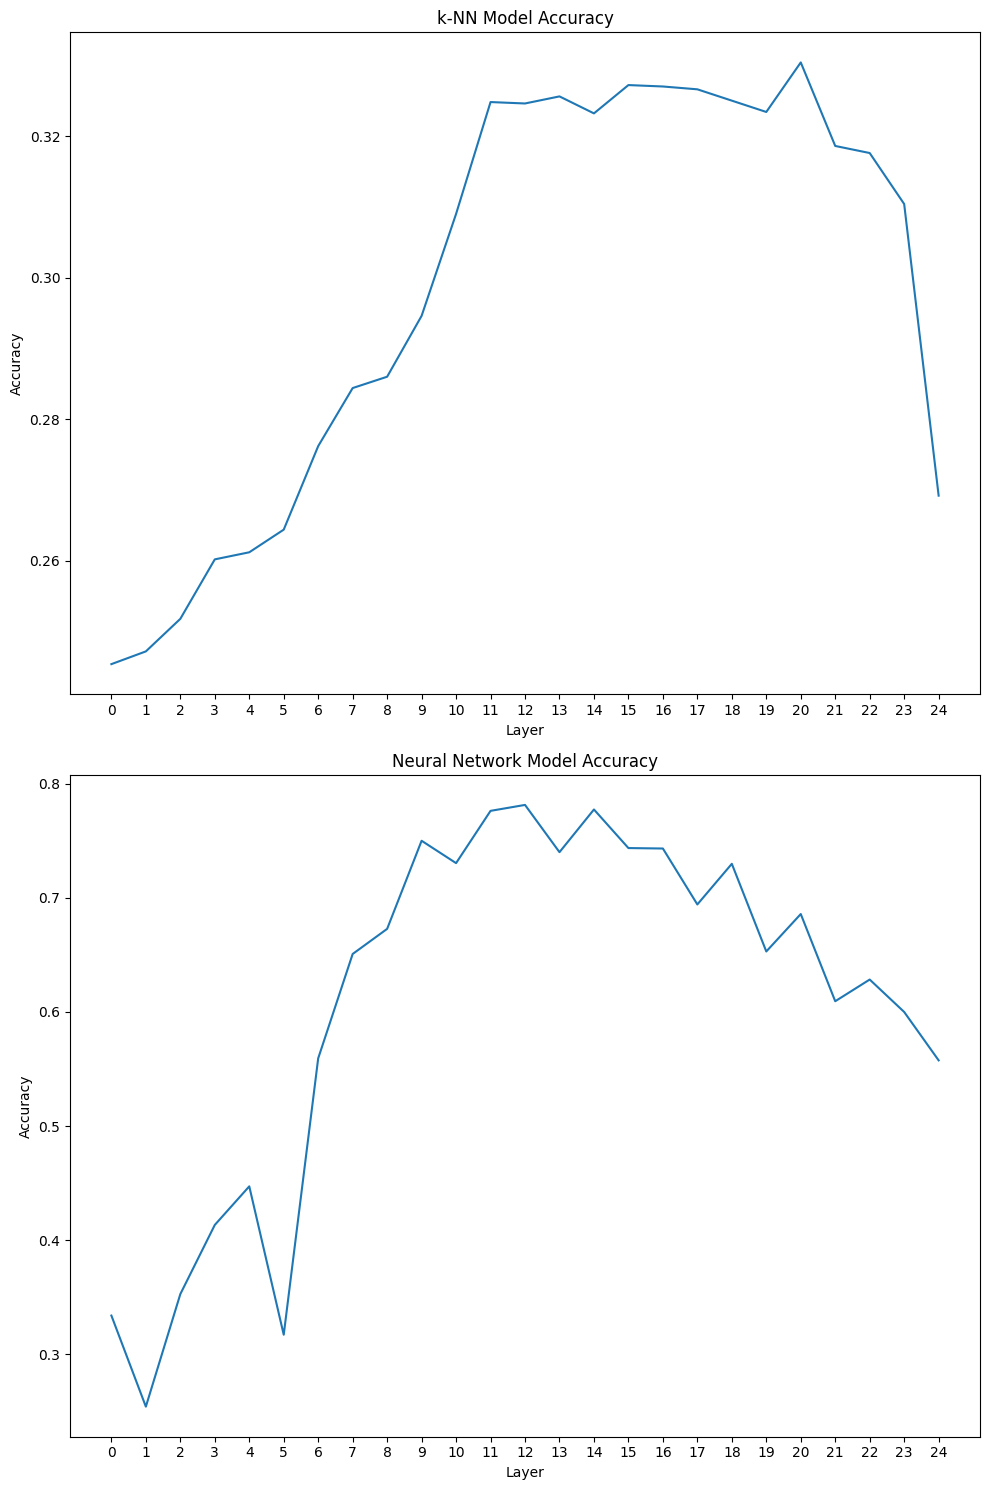

In [ ]:
# Plotting the results
# Now you can load the results later using:
# with open(cv_filename, 'rb') as f:
#     cv_scores = pickle.load(f)
# with open(tt_filename, 'rb') as f:
#     train_test_scores = pickle.load(f)
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
for i, (model_name, _) in enumerate(ml_models.items()):
    axs[i].set_title(f'{model_name} Model Accuracy')
    axs[i].set_xlabel('Layer')
    axs[i].set_ylabel('Accuracy')
    test_accuracies = [train_test_scores[layer_key][model_name][1] for layer_key in train_test_scores.keys()]
    axs[i].plot(range(len(test_accuracies)), test_accuracies)
    axs[i].set_xticks(range(len(test_accuracies)))
    axs[i].set_xticklabels(range(len(test_accuracies)))
plt.tight_layout()
plt.show()